# Analysis of Numila Performance

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [2]:
cd ~/Umila/numila

/Users/fred/Umila/numila


In [3]:
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import main
import utils
from numila import Numila

In [4]:
# Hide logging messages.
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

# Production accuracy

Numila slightly outperforms a trigram and bigram model on the BLEU utterance ordering task. The advantage disappears when `EXEMPLAR_THRESHOLD` is set to 1 (preventing any chunks from being stored in the graph).

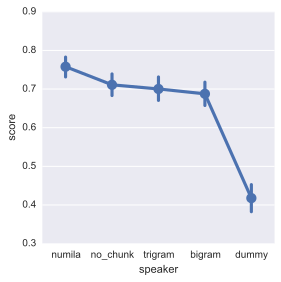

In [5]:
# The code for this simulation is not displayed here. We load previous results.
production = pd.read_pickle('pickles/simple_production.pkl')
production = production.loc[production.train_len == 8000]  # maximum train length
sns.factorplot(x='speaker', y='score', order=['numila', 'no_chunk', 'trigram', 'bigram', 'dummy'], data=production)

# Grammaticality judgement

Numila can provide a grammaticality score for any utterance. The score comes in two parts:

1. **Chunk ratio:** the percentage of possible chunks that were made.
2. **Chunkedness:** the geometric mean of the chunkiness of all chunks made in the parse.

To compare two scores, we first compare the chunk ratio, and then look to chunkedness in the case of a tie. This is similar to the metric used by Bod (2009). Note that the chunks in (1) need only surpass the `CHUNK_THRESHOLD` parameter, and thus need not be stored exemplars.

In [26]:
from scipy.stats import gmean

def nu_grammaticality(numila, utt):
    """Returns a grammaticality score for an utterance."""
    parse = numila.parse_utterance(utt, learn=False)
    possible_chunks = len(parse.utterance) - 1
    
    chunk_ratio = parse.num_chunks / possible_chunks    
    
    if parse.chunkinesses:
        chunkedness = gmean(parse.chunkinesses)
    else:  # no chunks made
        chunkedness = np.nan
    
    return (chunk_ratio, chunkedness)

To justify this choice of a grammaticality score, we will examine whether the two elements are indeed predictive of grammaticality. To create a test corpus, we take select 100 unseen unique utterances from the corpus and generate foils by swapping adjacent pairs of words, e.g. "the big dog barks" might become "big the dog barks". To keep the tasks from becoming too easy, we require that all test utterances have at least 4 words.

In [7]:
def swapped(lst):
    """Yields all versions of a list with one adjacent pair swapped.

    [1, 2, 3] -> [2, 1, 3], [1, 3, 2]
    """
    for idx in range(len(lst) - 1):
        swapped = list(lst)
        swapped[idx], swapped[idx+1] = swapped[idx+1], swapped[idx]
        yield swapped

def create_test_corpus(corpus, num_utterances):
    """Returns a test corpus with grammatical and neighbor-swapped utterances."""
    usable = (utt for utt in corpus if len(utt) > 3)
    correct = utils.take_unique(usable, num_utterances)
    foils = (foil for utt in correct for foil in swapped(utt))
    foils = set(tuple(utt) for utt in foils)  # ensure uniqueness
    return [('normal', utt) for utt in correct] + [('swapped', utt) for utt in foils]

Now we record number of chunks and chunk surprisal for each utterance in the test corpus. If our metric is a good one, we should be able to linearly separate the grammatical utterances from the altered foils based on these two dimensions

In [8]:
# Train the model.
corpus = main.syl_corpus()
train_corpus = [next(corpus) for _ in range(5000)]
numila = Numila().fit(train_corpus)

Numila train time: 162.580 seconds


In [27]:
# Run the simulation.
test_corpus = create_test_corpus(corpus, num_utterances=100)
data = []
for grammatical, utt in test_corpus:
    chunk_ratio, chunkedness = nu_grammaticality(numila, utt)
    data.append({'utterance_type': grammatical,
                 'length': len(utt),
                 'chunk_ratio': chunk_ratio,
                 'chunkedness': chunkedness})
grammaticality = pd.DataFrame(data)

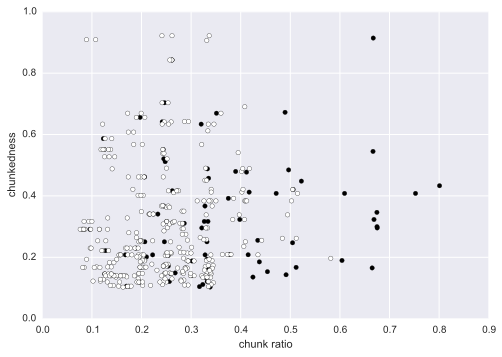

In [28]:
# Plot the results.
def jitter(arr):
    stdev = .01*(max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

plt = sns.plt
color_map = {'normal': 1, 'swapped': 0}
colors = [color_map[t] for t in grammaticality.utterance_type]
plt.scatter(jitter(grammaticality.chunk_ratio), grammaticality.chunkedness, c=colors)
plt.xlabel('chunk ratio')
plt.ylabel('chunkedness')

Above, we plot all utterances in the test corpus. Unaltered utterances are black.

We see that grammatical sentences tend to have more chunks than their neighbor-swapped foils. However, it does not appear that the stregnth of these chunks (i.e. chunkedness) is predictive of grammaticality. This indicates that the model's chunkiness score is only useful as a binary predictor. When two words are not at all chunkable (i.e. their chunkiness is below the `CHUNK_THRESHOLD` of 0.1), this is indicative of an ungrammatical sentence. However, the difference between a strong chunk and a weak chunk (as measured by chunkedness) is not predictive as far as we can tell.

We can confirm this by looking at summary statistics for each type of utterance:

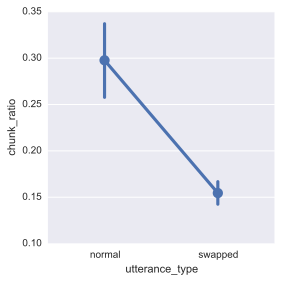

In [29]:
sns.factorplot('utterance_type', 'chunk_ratio', data=grammaticality)

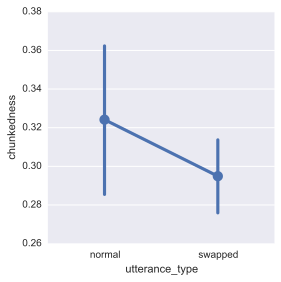

In [30]:
sns.factorplot('utterance_type', 'chunkedness', data=grammaticality)

In [90]:
grammaticality.head()

,chunk_ratio,chunkedness,length,utterance_type
0,0.666667,0.323174,4,normal
1,0.333333,0.457591,4,normal
2,0.500000,0.247263,7,normal
3,0.400000,0.477523,6,normal
4,0.000000,NaN,4,normal


## Precision and recall

To quantify the power of our grammaticality score, we test the model's precision and recall on the test set described above. We simulate a binary grammaticality judgement by choosing a threshold for each of the scores. By modifying this threshold, we can achieve a higher recall at the cost of precision and vice versa. We demonstrate this by plotting recall and precision for every possible recall value. I'm not sure how to explain how I did this, so here's the code:

In [60]:
def precision_recall(ranked):
    """Returns precisions and recalls on a test corpus with various thresholds.
    
    ranked is a list of utterance types, ranked by some metric.

    There is one data point for every correct utterance. These data points
    are the precision and recall if the model's grammaticality threshold is
    set to allow that utterance.
    """
    num_normal = ranked.count('normal')

    # Iterate through utterances, starting with best-ranked. Every time
    # we find a normal one, we add a new data point: the recall and precision
    # if the model were to set the threshold to allow only the utterances seen
    # so far.
    data = []
    normal_seen = 0
    num_seen = 0
    for utt_type in ranked:
        num_seen += 1
        if utt_type == 'normal':
            normal_seen += 1
            precision = normal_seen / num_seen
            recall = normal_seen / num_normal
            data.append({'precision': precision,
                         'recall': recall,
                         'F_score': np.sqrt(precision * recall)})
    return pd.DataFrame(data)

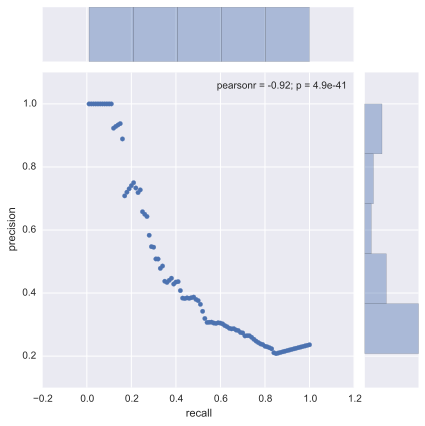

In [61]:
# We sort first by chunk_ratio, then by chunkedness. Thus this list
# is sorted by nu_grammaticality()
nu_ranked = grammaticality.sort_values(['chunk_ratio', 'chunkedness'], ascending=False)
nu_ranked_types = list(nu_ranked['utterance_type'])
nu_precision = precision_recall(nu_ranked_types)
sns.jointplot('recall', 'precision', data=nu_precision)

In [86]:
# Best F score for Nümila.
from operator import getitem
max((row for _, row in nu_precision.iterrows()),
    key=lambda row: row['F_score'])

F_score      0.485643
precision    0.235849
recall       1.000000
Name: 99, dtype: float64

The model attains the highest F score by setting the threshold low enough to mark all normal utterances as grammatical. This is not ideal behavior, but we note that the model does attain above chance performance:

In [69]:
# Chance precision performance.
nu_ranked_types.count('normal') / len(nu_ranked)

0.16556291390728478

## NGram comparison

We now run the same precision/recall test using an NGram model. The NGram model uses perplexity as a grammaticality metric.

In [ ]:
# Train NGram on same training corpus.
from ngram import NGramModel
trigram = NGramModel(3).fit(train_corpus)

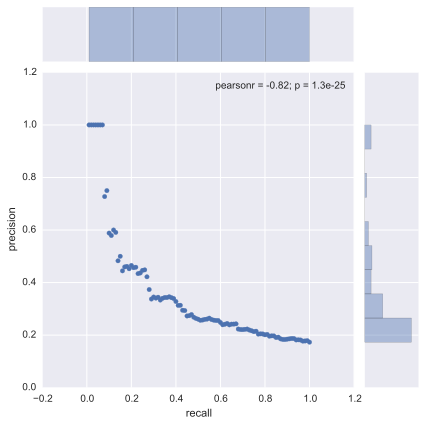

In [83]:
# Sort utterances by perplexity
utt_types, utts = zip(*test_corpus)
perplexities = trigram.perplexity(utts)
ngram_ranked = [typ for perp, typ in sorted(zip(perplexities, utt_types))]
ngram_precision = precision_recall(ngram_ranked)
sns.jointplot('recall', 'precision', data=ngram_precision)

In [89]:
# Best F score for NGram.
max((row for _, row in ngram_precision.iterrows()),
    key=lambda row: row['F_score'])

F_score      0.420611
precision    0.178700
recall       0.990000
Name: 98, dtype: float64

Like Nümila, the NGram achives the highest F score with a very low threshold. However, it has a lower precision than Nümila, and thus a lower F score.